In [1]:
using Gen
using Distributions
using Random
using Plots
using Genify

In [2]:
@gen function gbm_model(T::Int, S0::Float64, delta_t::Float64)
    # Latent parameters
    mu_var ~ normal(0.06, 0.01)  # drift
    sigma_var ~ normal(0.18, 0.05)  # volatility
    
    stock_prices = Float64[]
    S = S0
    
    for t in 1:T
        ε = @trace(normal(0.0, 1.0), (:epsilon, t))
        
        S = S * exp((mu_var - 0.5 * sigma_var^2) * delta_t + sigma_var * ε * sqrt(delta_t))
        
        # Observation with small noise
        obs = @trace(normal(S, 0.1), (:obs, t))
        push!(stock_prices, obs)
    end
    
    return stock_prices
end

DynamicDSLFunction{Any}(Dict{Symbol, Any}(), Dict{Symbol, Any}(), Type[Int64, Float64, Float64], false, Union{Nothing, Some{Any}}[nothing, nothing, nothing], Main.var"##gbm_model#277", Bool[0, 0, 0], false)

Observed stock prices (first 10):
[100.62286460944432, 101.25197666157078, 101.33757158514375, 100.80445096678409, 100.5210595480643, 100.57553233957604, 101.73688992844203, 101.20266084384362, 101.43274242234804, 101.59777471979042]

Latent parameters:
μ = 0.05709404120109122
σ = 0.2043239849708181


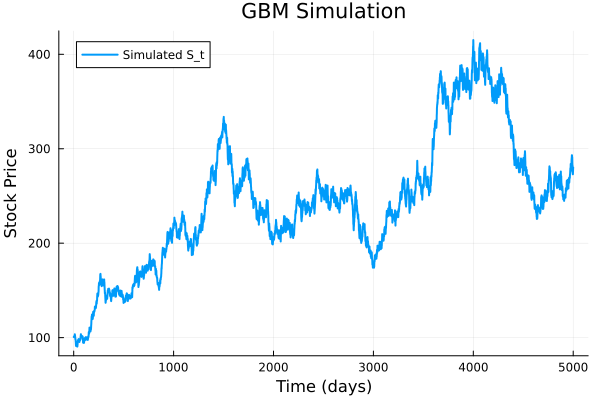

In [3]:
Random.seed!(50)
T = 5000
S0 = 100.0
delta_t = 1.0/365.0  # Daily time step

(trace, _) = generate(gbm_model, (T, S0, delta_t))
observations = get_retval(trace)

println("Observed stock prices (first 10):")
println(observations[1:10])

println("\nLatent parameters:")
println("μ = ", trace[:mu_var])
println("σ = ", trace[:sigma_var])

# Plot trajectory
using Plots
plot(1:T, observations, label="Simulated S_t", 
     xlabel="Time (days)", ylabel="Stock Price", 
     title="GBM Simulation", lw=2, legend=:topleft)